# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Откройте файл с данными и изучите общую информацию

In [1]:
# импорт необходимых для работы библиотек

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from pymystem3 import Mystem

In [2]:
# чтение файла и сохранение в переменную data

try:
    data = pd.read_csv('/datasets/data.csv')
except:
    print('Невозможно открыть файл')
        
# вывод первых десяти строк таблицы
display(data.head(10))

# вывод сводной информации по датафрейму
data.info()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Вывод**

Итак, в датасете содержится 11 столбцов, соответствующих социальным характеристикам заёмщика, а также отражающих его кредитную историю. На первый взгляд, в таблице имеются неоднозначные названия колонок, пропуски данных, некорректные типы значения переменных и их типы. 

## Предобработка данных
Для продолжения работы требуется надлежащим образом подготовить данные.

### Исправление названий столбцов
Некорректные названия столбцов могут вводить в заблуждение, поэтому, прежде чем приступать к очистке и обогащению данных, следует присвоить колонкам более интуитивные названия.

In [3]:
# текущие названия столбцов

data.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

In [4]:
# dob_years → client_age
# income_type → occupation
# debt → had_debt

data = data.rename(columns={'dob_years':'client_age','income_type':'occupation','debt':'had_debt'})

### Удаление явных дубликатов
Наличие дубликатов может внести искажение в результаты исследования, поэтому от них стоит избавиться как можно скорее, чтобы обогащать данными лишь уникальные строки.

In [5]:
# Проверка количества явных дубликатов

data.duplicated().sum()

54

In [6]:
# удаление явных дубликатов

data = data.drop_duplicates().reset_index(drop=True)

### Исправление данных

#### Количество детей `children`


Оценим разброс значений в колонке

In [7]:
# вывод частоты встречаемости каждого уникального значения в столбце `children`

data['children'].value_counts()

 0     14107
 1      4809
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Значение `-1` скорее всего имеет тот же смысл, что и NaN: "Отсутствие", "Неизвестно", "Не применимо" и т.д.. Поэтому эти строки логичней всего отнести к значению `children = 0`. 
Количество детей `20` теоретически возможно, но настораживает, во-первых, полное отсутствие значений от `6` до `19`, во-вторых, количество таких записей. Вероятно, на каком-то этапе значение имело тип `float` и записывалось как `2.0` и впоследствии некорректно перенеслось из одной базы в другую. Заменим эти значения в соответствии с выдвинутой гипотезой.

In [8]:
# замена числа детей в семье с -1 на 0 и с 20 на 2

data.replace((-1, 20),(0,2),inplace=True)

Несмотря на то, что количество детей само по себе является категорией, в некоторых категориях количество наблюдений недостаточно, поэтому следует разделить всех заемщиков на следующие группы:
* бездетная семья
* семья с детьми
* многодетная семья

In [9]:
def children_grader(value):
    if value==0:
        return 'бездетная семья'
    elif value<3:
        return 'семья с детьми'
    return 'многодетная семья'

In [10]:
data.insert(1, 'children_grade', value=data['children'].apply(children_grader))

#### Трудовой стаж `days_employed`

Оценим разброс значений в колонке с указанием трудового стажа клиента. Для этого найдем минимальное и максимальное значение в колонке, а также построим график boxplot.

Минимальное значение в колонке составляет -18388.949900568383
Максимальное значение в колонке составляет 401755.40047533


<AxesSubplot:>

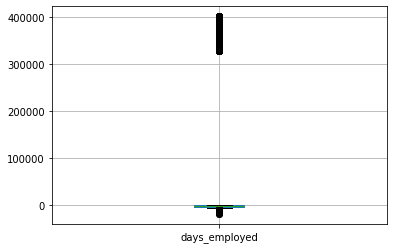

In [11]:
print(f"Минимальное значение в колонке составляет {data['days_employed'].min()}")
print(f"Максимальное значение в колонке составляет {data['days_employed'].max()}")
data.boxplot(column='days_employed')

In [12]:
# вывод количества NaN в колонке

data['days_employed'].isna().sum()

2120

В столбце присутствуют отрицательные, запредельные значения, и NaN. Присутствие отрицательных значений может быть связано с повреждением данных при переносе, тем более, что их абсолютные величины вполне адекватны.

Приведем все значения к абсолютным величинам:


In [13]:
# переприсвоение всем значениям их модуля

data['days_employed'] = abs(data['days_employed'])

Чтобы функция приведения к типу отработала безошибочно, заменим все NaN на -1, а аномальные значения разделим на 24, исходя из гипотезы о том, что данные записаны в часах.

In [14]:
# замена всех NaN значений трубового стажа на -1
data.loc[data['days_employed'].isna(), 'days_employed'] = -1

# деление всех значений трудового стажа больше 30000 дней на 24
data.loc[data['days_employed']>30000, 'days_employed'] = data['days_employed']/24

Теперь, когда в колонке не осталось значений NaN, можно привести все значения к целому типу.

In [15]:
# приведение всех значений в колонке с трудовым стажем к int
data['days_employed'] = data['days_employed'].astype('int')

# вывод первых пяти строк датафрейма
data['days_employed'].head(5)

0     8437
1     4024
2     5623
3     4124
4    14177
Name: days_employed, dtype: int64

#### Возраст клиента `client_age`

Оценим диапазон возраста клиентов в датасете.

In [16]:
# вывод уникальных значений из столбца с возрастом клиента

data['client_age'].sort_values().unique()

array([ 0,  2, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75])

In [17]:
# вывод отчета об отсутствующих даных в столбце с возрастом клиента

print(f"Возраст не указан в {data[data['client_age']==0]['client_age'].count()} записи.")

Возраст не указан в 101 записи.


Заполним пустые ячейки с возрастом медианным значением, рассчитанным по каждой категории признака "семейное положение"

In [18]:
# создание Series с соответствующим медианным значением для каждого индекса исходной 

med_age = data.groupby(by='family_status')['client_age'].transform('median')

Для ускорения расчетов проведем замены в два этапа. Сначала заменим все нули на NaN, а после - все NaN - на необходимое значение.

In [19]:
# замена всех нулей на NaN 
data['client_age'] = data['client_age'].replace(0, np.NaN)

# замена всех NaN на медианное значение
data['client_age'] = data['client_age'].fillna(med_age).astype('int')

####  Образование `education`

Исследуем разнообразие значений, введенных в поле `education`.

In [20]:
# вывод уникальных значений из столбца с уровнем образования клиента банка

data['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

В колонке присутствует большое количество неявных повторений. Избавиться от них можно изменением регистра текста.

In [21]:
# приведение регистра текста к строчному

data['education'] = data['education'].str.lower()

Оценим количество записей для оставшихся вариантов уровня образования

In [22]:
# расчет количества пользователей в каждой уникальной категории уровня образования

data['education'].value_counts()

среднее                15188
высшее                  5251
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

По федеральному закону "Об образовании в Российской Федерации»" минимальным уровнем образования является среднее, поэтому `начальное` и `неоконченное высшее` следует отнести к `среднему`, тем более они не представляют собой больших и значимых для исследования групп. Лиц, имеющих `ученую степень`, также крайне мало, поэтому их разумно отнести к `высшему` образованию.

In [23]:
# замена значений уровня образования 'начальное' на 'среднее'
data.loc[data['education']=='начальное', 'education'] = 'среднее'

# замена значений уровня образования 'неоконченное высшее' на 'среднее'
data.loc[data['education']=='неоконченное высшее', 'education'] = 'среднее'

# замена значений уровня образования 'ученая степень' на 'высшее'
data.loc[data['education']=='ученая степень', 'education'] = 'высшее'

In [24]:
print(f'После обработки регистра обнаружено {data.duplicated().sum()} новых дубликатов, которые следует удалить')

После обработки регистра обнаружено 18 новых дубликатов, которые следует удалить


In [25]:
data = data.drop_duplicates().reset_index(drop=True)

#### Идентификатор уровня образования `education_id`

На предыдущем этапе мы избавились от нескольких категорий уровня образования, поэтому в столбце с уникальным идентификатором тоже следует провести замены. 

In [26]:
# переприсвоение идентификаторов среднего образования
data.loc[data['education']=='среднее', 'education_id'] = 0

# переприсвоение идентификаторов высшего образования
data.loc[data['education']=='высшее', 'education_id'] = 1

#### Семейное положение `family_status`

Оценим содержимое колонки с семейным положением клиентов.

In [27]:
# вывод уникальных значений из колонки с семейным положением

data['family_status'].value_counts()

женат / замужем          12339
гражданский брак          4150
Не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

В столбце только уникальные значения, замены не требуются.

#### Идентификатор семейного положения `family_status_id`

Проверим соответствие колонок `family_status` и `family_status_id`. Для этого выведем сводную таблицу, которая, в случае верного соответствиия семейного положения и соответствующего идентификатора, должна представлять собой диагональную матрицу с количеством записей для каждого идентификатора.

In [28]:
# создание сводной таблицы для сопоставления значения из колонки и его идентификатора

data.pivot_table(index='family_status', columns='family_status_id', values='children', aggfunc='count')

family_status_id,0,1,2,3,4
family_status,,,,,
Не женат / не замужем,NaN,NaN,NaN,NaN,2810.0
в разводе,NaN,NaN,NaN,1195.0,NaN
вдовец / вдова,NaN,NaN,959.0,NaN,NaN
гражданский брак,NaN,4150.0,NaN,NaN,NaN
женат / замужем,12339.0,NaN,NaN,NaN,NaN


Действительно, каждому виду семейного положения присвоен уникальный ключ.

#### Пол  клиента `gender`

Рассмотрим значения в колонке с указанием пола пользователя.

In [29]:
# вывод уникальных значений из колонки с гендером

data['gender'].value_counts()

F      14173
M       7279
XNA        1
Name: gender, dtype: int64

Для одного из клиентов не указан пол. Возможно, клиент банка действительно не захотел его указывать, либо сотрудники не смогли распознать его по онлайн поданной заявке.
Как бы то ни было, данная строка содержит ценные для исследования данные, поэтому удалять ее не следует, лучше восстановить значение. Более вероятно, что запись относится к категории с большим количествоу участников.

In [30]:
# замена неуказанного пола на женский

data['gender'].replace('XNA', 'F', inplace=True)

#### Род деятельности `occupation`

Оценим разнообразие категорий в колонке с родом деятельности.

In [31]:
# вывод уникальных значений из колонки с родом деятельности

data['occupation'].value_counts()

сотрудник          11083
компаньон           5078
пенсионер           3829
госслужащий         1457
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: occupation, dtype: int64

Последние четыре категории представлены всего несколькими записями, поэтому не позволят сделать обобщенных выводов относительно  представителей таких видов деятельности.

In [32]:
data[(data['occupation']!='сотрудник') &
     (data['occupation']!='компаньон') &
     (data['occupation']!='пенсионер') &
     (data['occupation']!='госслужащий')
    ]

,children,children_grade,days_employed,client_age,education,education_id,family_status,family_status_id,gender,occupation,had_debt,total_income,purpose
3132,1,семья с детьми,14063,31,среднее,0,женат / замужем,0,M,безработный,1,59956.991984,покупка жилья для сдачи
5931,0,бездетная семья,-1,58,высшее,1,женат / замужем,0,M,предприниматель,0,NaN,покупка жилой недвижимости
9399,0,бездетная семья,578,22,высшее,1,Не женат / не замужем,4,M,студент,0,98201.625314,строительство собственной недвижимости
14766,0,бездетная семья,16470,45,высшее,1,гражданский брак,1,F,безработный,0,202722.511368,ремонт жилью
18646,0,бездетная семья,520,27,высшее,1,гражданский брак,1,F,предприниматель,0,499163.144947,на проведение свадьбы
20777,2,семья с детьми,3296,39,среднее,0,женат / замужем,0,F,в декрете,1,53829.130729,автомобиль


Однако, в строках содержатся другие, не менее ценные для исследования данные, поэтому избавляться от них также как и в случае с полом не стоит.

#### Наличие задолженностей по кредиту `had_debt`

In [33]:
# вывод уникальных значений из колонки с фактом имеющихся задолженностей по кредиту

data['had_debt'].value_counts()

0    19712
1     1741
Name: had_debt, dtype: int64

Столбец с целевой переменной не содержит пропусков. Однако этому столбцу больше подходит булевый тип переменной.

In [34]:
# приведенеие всех значений к булеву типу

data['had_debt'] = data['had_debt'].astype('bool')

#### Ежемесячный доход `total_income`

Возвращаясь к обзору датафрейма, нужно вспомнить, что в столбце с доходом пользователей отсутствовали некоторые значения. Получим их количество:

In [35]:
# вывод количества NaN в колонке

data['total_income'].isna().sum()

2102

Восстановим пропуски медианным значением по сочетанию категорий `client_age` и `gender`. К сожалению, именно по гендерному и возрастному признакам доход клиентов отличается сильнее всего.

In [36]:
# создание сводной таблицы сопоставления доходов мужчин и женщин разных возрастов
age_gender_pivot = data.pivot_table(index='client_age', columns='gender', values='total_income', aggfunc='median')

# добавление к сводной таблице столбца с процентной разницей между доходами мужчин и женщин
age_gender_pivot['difference_percent'] = 100*(age_gender_pivot['F'] - age_gender_pivot['M']) / age_gender_pivot['F']

# вывод сводной таблицы
age_gender_pivot[['F', 'M', 'difference_percent']]

gender,F,M,difference_percent
client_age,,,
2,101512.989536,134750.749515,-32.742371
19,112217.756662,91876.754772,18.126367
21,112778.853259,147812.788085,-31.064277
22,111633.034748,158258.854591,-41.767045
23,117755.877467,137544.158776,-16.804496
24,122938.149557,153115.076039,-24.546430
25,131764.441672,161883.762815,-22.858459
26,132408.440852,165998.158511,-25.368260
27,142601.204718,170124.764755,-19.301071


Напишем функцию, заполняющую отсутствующие значения медианным для обобщенной по полу и возрасту категории.

In [37]:
# создание функции

def func(row):
    if math.isnan(row['total_income']):                                  # если значение является NaN
        return age_gender_pivot.loc[row['client_age'], row['gender']]    #   вернуть значение из сводной таблицы для указанного пола и возраста
    else:                                                                # иначе
        return row['total_income']                                       #   вернуть то же значение

In [38]:
# применение функции к датафрейму и приведение всех значений к типу int

data['total_income'] = data.apply(func, axis=1).astype('int')

Разделим всех пользователей на три условных группы по уровню дохода:
* Низкий доход (low_income)
* Средний доход (medium_income)
* Высокий доход (high_income)

В первую группу войдут клиенты, чей доход находится в первом квартиле распределения значений в столбце `total_income`. В третью - четвертый квартиль. Все остальные пользователи войдут в группу `medium_income`. Благодаря такому распределению размеры групп будут иметь один порядок, а средний доход будет иметь половина клиентов банка.

In [39]:
# написание функции разделения клиентов на группы по уровню дохода

def income_grader(value):
    if value < data['total_income'].quantile(0.25):
        return 'Низкий доход'
    elif value > data['total_income'].quantile(0.75):
        return 'Высокий доход'
    else:
        return 'Средний доход'

In [40]:
# создание нового столбца в положении 11 и заполнение его категориями в соответствии с написанной функцией

data.insert(11, 'income_grade', value=data['total_income'].apply(income_grader)) 

In [41]:
# вывод первых пяти строк датафрейма

data.head(5)

,children,children_grade,days_employed,client_age,education,education_id,family_status,family_status_id,gender,occupation,had_debt,income_grade,total_income,purpose
0,1,семья с детьми,8437,42,высшее,1,женат / замужем,0,F,сотрудник,False,Высокий доход,253875,покупка жилья
1,1,семья с детьми,4024,36,среднее,0,женат / замужем,0,F,сотрудник,False,Средний доход,112080,приобретение автомобиля
2,0,бездетная семья,5623,33,среднее,0,женат / замужем,0,M,сотрудник,False,Средний доход,145885,покупка жилья
3,3,многодетная семья,4124,32,среднее,0,женат / замужем,0,M,сотрудник,False,Высокий доход,267628,дополнительное образование
4,0,бездетная семья,14177,53,среднее,0,гражданский брак,1,F,пенсионер,False,Средний доход,158616,сыграть свадьбу


In [42]:
# вывод сводной информации о датасете

data.describe()

,children,days_employed,client_age,education_id,family_status_id,total_income
count,21453.000000,21453.000000,21453.000000,21453.000000,21453.000000,2.145300e+04
mean,0.478395,4186.297254,43.428705,0.245001,0.973896,1.652416e+05
std,0.756020,5270.688047,12.330976,0.430098,1.421601,9.821082e+04
min,0.000000,-1.000000,2.000000,0.000000,0.000000,2.066700e+04
25%,0.000000,622.000000,33.000000,0.000000,0.000000,1.073100e+05
50%,0.000000,1822.000000,43.000000,0.000000,0.000000,1.433620e+05
75%,1.000000,4797.000000,53.000000,0.000000,1.000000,1.958180e+05
max,5.000000,18388.000000,75.000000,1.000000,4.000000,2.265604e+06


**Вывод**

Данные приведены в порядок. Дубликаты удалены, некорректные данные заменены корректными в соответствии с выдвинутыми гипотезами, исправлены типы данных.

### Лемматизация

В колонке `purpose` в достаточно свободной форме описана цель, с которой клиент брал кредит в банке. Чтобы иметь возможность сравнить цели пользователей, формулировки необходимо лемматизировать.

In [43]:
# написание функции, разделяющей словосочетания на леммы

m = Mystem()                         # вызов экземпляра класса Mystem()
def lemmatized(value):               # объявление функции
    lst = list(m.lemmatize(value))   # создание списка из лемм, обнаруженных в ячейке
    while ' ' in lst:                # удаление из списка пустых строк
        lst.remove(' ')              # -//-
    lst.remove('\n')                 # удаление из списка символов переноса строки
    return lst                       # возвращение очищенного списка

In [44]:
# применение написанной функции к новому столбцу 'purpose_lemmas'

data['purpose_lemmas'] = data['purpose'].apply(lemmatized)

In [45]:
# вывод первых пяти строк датафрейма

data.head()

,children,children_grade,days_employed,client_age,education,education_id,family_status,family_status_id,gender,occupation,had_debt,income_grade,total_income,purpose,purpose_lemmas
0,1,семья с детьми,8437,42,высшее,1,женат / замужем,0,F,сотрудник,False,Высокий доход,253875,покупка жилья,"[покупка, жилье]"
1,1,семья с детьми,4024,36,среднее,0,женат / замужем,0,F,сотрудник,False,Средний доход,112080,приобретение автомобиля,"[приобретение, автомобиль]"
2,0,бездетная семья,5623,33,среднее,0,женат / замужем,0,M,сотрудник,False,Средний доход,145885,покупка жилья,"[покупка, жилье]"
3,3,многодетная семья,4124,32,среднее,0,женат / замужем,0,M,сотрудник,False,Высокий доход,267628,дополнительное образование,"[дополнительный, образование]"
4,0,бездетная семья,14177,53,среднее,0,гражданский брак,1,F,пенсионер,False,Средний доход,158616,сыграть свадьбу,"[сыграть, свадьба]"


Выделим уникальные слова в столбце с леммами.

In [46]:
# вывод строки, в которой через запятую перечислены все леммы, встречающиеся в колонке 'purpose_lemmas'

', '.join(set(data['purpose_lemmas'].sum()))

'сыграть, операция, автомобиль, недвижимость, на, покупка, коммерческий, для, приобретение, сделка, с, образование, высокий, заниматься, подержанный, жилой, собственный, проведение, со, получение, жилье, семья, свадьба, сдача, профильный, строительство, подержать, ремонт, свой, дополнительный'

В списке прослеживается несколько основных целей, для реализации которых клиенты брали кредиты: покупка автомобиля, сделки с недвижимостью, расходы на образование и свадьбу. Добавим эти категории в датасет.

In [47]:
# написание функции категоризации целей кредита

def definite_purpose (value):                               # объявление функции
    if 'автомобиль' in value:                               # если в списке встречается слово "автомобиль"
        return 'авто'                                       #    вернуть "авто"
    elif ('жилье' in value) or ('недвижимость' in value):   # если встречается слово "жилье" или "недвижимость"
        return 'недвижимость'                               #    вернуть "недвижимость"
    elif 'образование' in value:                            # если встречается слово "образование"
        return 'образование'                                #    вернуть "образование"
    elif 'свадьба' in value:                                # если встречается слово "свадьба"
        return 'свадьба'                                    #    вернуть "свадьба"
    else:                                                   # иначе
        return 'не определено'                              #    вернуть "не определено"

In [48]:
# применение написанной функции к колонке 'purpose_lemmas' и запись значений в колонку 'purpose'

data['purpose'] = data['purpose_lemmas'].apply(definite_purpose)

In [49]:
# вывод уникальных значений из колонки 'purpose'

data['purpose'].value_counts()

недвижимость    10811
авто             4306
образование      4013
свадьба          2323
Name: purpose, dtype: int64

Все записи удалось отнести к определенной категории. Поскольку столбец `purpose_lemmas` больше не требуется, избавимся от него.

In [50]:
# удаление колонки 'purpose_lemmas'

data.drop('purpose_lemmas', axis=1, inplace=True) 

In [51]:
# вывод первых пяти строк датафрейма

data.head()

,children,children_grade,days_employed,client_age,education,education_id,family_status,family_status_id,gender,occupation,had_debt,income_grade,total_income,purpose
0,1,семья с детьми,8437,42,высшее,1,женат / замужем,0,F,сотрудник,False,Высокий доход,253875,недвижимость
1,1,семья с детьми,4024,36,среднее,0,женат / замужем,0,F,сотрудник,False,Средний доход,112080,авто
2,0,бездетная семья,5623,33,среднее,0,женат / замужем,0,M,сотрудник,False,Средний доход,145885,недвижимость
3,3,многодетная семья,4124,32,среднее,0,женат / замужем,0,M,сотрудник,False,Высокий доход,267628,образование
4,0,бездетная семья,14177,53,среднее,0,гражданский брак,1,F,пенсионер,False,Средний доход,158616,свадьба


**Вывод**

Из общего списка формулировок целей, с которыми клиенты банка брали кредиты, путем лемматизации выделены наиболее характерные. Каждой записи о выданном кредите присвоен одна из нескольких категорий.

In [52]:
data[data.duplicated()].sort_values(by='total_income')

,children,children_grade,days_employed,client_age,education,education_id,family_status,family_status_id,gender,occupation,had_debt,income_grade,total_income,purpose
9183,0,бездетная семья,-1,68,среднее,0,женат / замужем,0,F,пенсионер,False,Низкий доход,100967,недвижимость
8423,0,бездетная семья,-1,67,среднее,0,женат / замужем,0,F,пенсионер,False,Низкий доход,105743,образование
16829,0,бездетная семья,-1,67,среднее,0,женат / замужем,0,F,пенсионер,False,Низкий доход,105743,образование
17299,0,бездетная семья,-1,67,среднее,0,женат / замужем,0,F,пенсионер,False,Низкий доход,105743,недвижимость
18337,0,бездетная семья,-1,21,среднее,0,гражданский брак,1,F,сотрудник,False,Средний доход,112778,недвижимость
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19265,0,бездетная семья,-1,49,среднее,0,женат / замужем,0,M,сотрудник,False,Средний доход,188417,недвижимость
8716,1,семья с детьми,-1,42,среднее,0,женат / замужем,0,M,сотрудник,False,Средний доход,194077,недвижимость
7689,0,бездетная семья,-1,42,среднее,0,Не женат / не замужем,4,M,сотрудник,False,Средний доход,194077,недвижимость
17201,0,бездетная семья,-1,42,среднее,0,женат / замужем,0,M,сотрудник,False,Средний доход,194077,авто


### Исследование данных по категориям

Целью исследования является вывод о том, как влияет тот или иной социальный признак на вероятность возврата кредита. Поэтому выделим четыре целевых признака и для каждого построим сводную таблицу, в которой каждой категории признака будет соответствовать вероятность не вернуть кредит. 
* Количество детей
* Семейное положение
* Уровень дохода
* Цель кредита

In [53]:
# создание таблицы, отражающей количество взятых и просроченных кредитов для каждой из категорий признака "количество детей"
children_feature_reliability = data.groupby(by='children_grade').agg({'had_debt':['count', 'sum']})

# добавление к таблице столбца с вероятностью возврата кредита для каждой из категорий
children_feature_reliability['risks'] = children_feature_reliability['had_debt']['sum'] / children_feature_reliability['had_debt']['count']

# сортировка таблицы по убыванию вероятности возврата кредита
children_feature_reliability.sort_values(by='risks', ascending=False)

had_debt           risks
                     count   sum          
children_grade                            
семья с детьми        6936   646  0.093137
многодетная семья      380    31  0.081579
бездетная семья      14137  1064  0.075263

In [54]:
# создание таблицы, отражающей количество взятых и просроченных кредитов для каждой из категорий признака "семейное положение"
family_feature_reliability = data.groupby(by='family_status').agg({'had_debt':['count', 'sum']})

# добавление к таблице столбца с вероятностью невозврата кредита для каждой из категорий
family_feature_reliability['risks'] = family_feature_reliability['had_debt']['sum'] / family_feature_reliability['had_debt']['count']

# сортировка таблицы по убыванию вероятности невозврата кредита
family_feature_reliability.sort_values(by='risks', ascending=False)

had_debt          risks
                         count  sum          
family_status                                
Не женат / не замужем     2810  274  0.097509
гражданский брак          4150  388  0.093494
женат / замужем          12339  931  0.075452
в разводе                 1195   85  0.071130
вдовец / вдова             959   63  0.065693

In [55]:
# создание таблицы, отражающей количество взятых и просроченных кредитов для каждой из категорий признака "уровень дохода"
income_feature_reliability = data.groupby(by='income_grade').agg({'had_debt':['count', 'sum']})

# добавление к таблице столбца с вероятностью невозврата кредита для каждой из категорий
income_feature_reliability['risks'] = income_feature_reliability['had_debt']['sum'] / income_feature_reliability['had_debt']['count']

# сортировка таблицы по убыванию вероятности невозврата кредита
income_feature_reliability.sort_values(by='risks', ascending=False)

had_debt          risks
                 count  sum          
income_grade                         
Средний доход    10727  932  0.086884
Низкий доход      5363  426  0.079433
Высокий доход     5363  383  0.071415

In [56]:
# создание таблицы, отражающей количество взятых и просроченных кредитов для каждой из категорий признака "цель кредита"
purpose_feature_reliability = data.groupby(by='purpose').agg({'had_debt':['count', 'sum']})

# добавление к таблице столбца с вероятностью невозврата кредита для каждой из категорий
purpose_feature_reliability['risks'] = purpose_feature_reliability['had_debt']['sum'] / purpose_feature_reliability['had_debt']['count']

# сортировка таблицы по убыванию вероятности невозврата кредита
purpose_feature_reliability.sort_values(by='risks', ascending=False)

had_debt          risks
                count  sum          
purpose                             
авто             4306  403  0.093590
образование      4013  370  0.092200
свадьба          2323  186  0.080069
недвижимость    10811  782  0.072334

**Вывод**

Выведенные для каждой категории показатели вероятности не имеют выраженных отклонений, однако с учетом объемов кредитования банки обязаны учитывать даже несколько процентов разницы, чтобы не получить убытки от невозвращенных кредитов.

### Исследование данных по совместным признакам

Гораздо интересней исследовать совокупное влияние признака на вероятность возврата кредита. Для этого построим совокупные сводные таблицы для каждой пары признаков. Для четырех признаков таких таблиц должно быть 6. Сразу необходимо ввести уточнение, что вероятность возврата кредита будет рассчитываться только для достаточно больших групп (не менее ста участников), иначе выводы могут быть искажены.

#### Исследование совокупного влияния признаков `children_grade` - `family_status`

In [57]:
''' 
Таблица строится в осях соответствующего признака 
и заполняется рассчитанной вероятностью возврата кредита (выведенной в процентах и округленной до десятых).
Через '/' записывается количество наблюдений в группе.
Группы с количеством наблюдений заменются пустой строкой.
Все NaN заменяются на пустую строку.
'''

children_family_status_pivot = data.pivot_table(index='children_grade', columns='family_status', values='had_debt', 
              aggfunc=lambda x: str(round(100*(sum(x)/len(x)), 1))+'% / '+str(len(x)) if len(x)>100  else '').fillna('')
children_family_status_pivot

family_status,Не женат / не замужем,в разводе,вдовец / вдова,гражданский брак,женат / замужем
children_grade,,,,,
бездетная семья,9.3% / 2267,7.0% / 788,6.2% / 851,8.4% / 2734,6.9% / 7497
многодетная семья,,,,,7.0% / 285
семья с детьми,11.6% / 533,7.3% / 395,9.9% / 101,11.2% / 1350,8.6% / 4557


#### Исследование совокупного влияния признаков `children_grade` - `income_grade`

In [58]:
# 'children_grade' - 'income_grade'

children_income_grade_pivot = data.pivot_table(index='children_grade', columns='income_grade', values='had_debt', 
              aggfunc=lambda x: str(round(100*(sum(x)/len(x)), 1))+'% / '+str(len(x)) if len(x)>100  else '').fillna('')
children_income_grade_pivot

income_grade,Высокий доход,Низкий доход,Средний доход
children_grade,,,
бездетная семья,6.8% / 3457,7.2% / 3657,8.0% / 7023
многодетная семья,4.9% / 102,,8.4% / 202
семья с детьми,7.9% / 1804,9.4% / 1630,10.0% / 3502


#### Исследование совокупного влияния признаков `children_grade` - `purpose`

In [59]:
# 'children_grade' - 'purpose'

children_family_status_pivot = data.pivot_table(index='children_grade', columns='purpose', values='had_debt', 
              aggfunc=lambda x: str(round(100*(sum(x)/len(x)), 1))+'% / '+str(len(x)) if len(x)>100  else '').fillna('')
children_family_status_pivot

purpose,авто,недвижимость,образование,свадьба
children_grade,,,,
бездетная семья,8.5% / 2856,6.7% / 7098,8.6% / 2652,7.5% / 1531
многодетная семья,,8.2% / 195,,
семья с детьми,11.1% / 1378,8.2% / 3518,10.7% / 1284,8.7% / 756


#### Исследование совокупного влияния признаков `family_status` - `income_grade`

In [60]:
# 'family_status' - 'income_grade'

family_status_income_grade_pivot = data.pivot_table(index='family_status', columns='income_grade', values='had_debt', 
              aggfunc=lambda x: str(round(100*(sum(x)/len(x)), 1))+'% / '+str(len(x)) if len(x)>100  else '').fillna('')
family_status_income_grade_pivot

income_grade,Высокий доход,Низкий доход,Средний доход
family_status,,,
Не женат / не замужем,9.3% / 706,8.4% / 666,10.6% / 1438
в разводе,6.2% / 307,7.5% / 293,7.4% / 595
вдовец / вдова,6.6% / 167,4.7% / 319,7.8% / 473
гражданский брак,6.7% / 1043,9.2% / 1044,10.8% / 2063
женат / замужем,6.9% / 3140,7.8% / 3041,7.7% / 6158


#### Исследование совокупного влияния признаков `family_status` - `purpose`

In [61]:
# 'family_status' - 'purpose'

family_status_purpose_pivot = data.pivot_table(index='family_status', columns='purpose', values='had_debt', 
              aggfunc=lambda x: str(round(100*(sum(x)/len(x)), 1))+'% / '+str(len(x)) if len(x)>100  else '').fillna('')
family_status_purpose_pivot

purpose,авто,недвижимость,образование,свадьба
family_status,,,,
Не женат / не замужем,12.9% / 637,8.1% / 1596,10.7% / 577,
в разводе,7.5% / 281,7.0% / 676,7.1% / 238,
вдовец / вдова,9.2% / 218,5.2% / 542,7.5% / 199,
гражданский брак,11.8% / 434,9.2% / 989,14.9% / 404,8.0% / 2323
женат / замужем,8.4% / 2736,6.9% / 7008,8.3% / 2595,


#### Исследование совокупного влияния признаков `income_grade` - `purpose`

In [62]:
# 'income_grade' - 'purpose'

income_grade_purpose_pivot = data.pivot_table(index='income_grade', columns='purpose', values='had_debt', 
              aggfunc=lambda x: str(round(100*(sum(x)/len(x)), 1))+'% / '+str(len(x)) if len(x)>100  else '').fillna('')
income_grade_purpose_pivot

purpose,авто,недвижимость,образование,свадьба
income_grade,,,,
Высокий доход,8.5% / 1089,6.8% / 2754,7.9% / 944,5.0% / 576
Низкий доход,9.6% / 1047,6.8% / 2671,8.7% / 1041,8.9% / 604
Средний доход,9.7% / 2170,7.7% / 5386,10.1% / 2028,9.0% / 1143


**Выводы**

В расширенном анализе по парам признаков проявились более заметные расхождения. Поэтому можно предположить, что по мере детализации портрета заемщика, то есть описания его при помощи большего числа критериев, точность предсказания его кредитного рейтинга будет расти. Однако такая подробность описания требует достаточного количества наблюдений в каждой подгруппе, поэтому в рамках этого исследования максимальное число признаков ограничилось двумя. Кроме того, определенных ухищрений требует визуальная интерпретация значений, полученных по трем переменным.

## Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

В датасете содержится недостаточно данных, чтобы сделать обобщенный вывод о надежности многодетных заемщиков (больше двух детей в семье), однако в целом семьи с детьми, как ни странно, оказались менее надежными с точки зрения вероятности своевременного возврата кредита. Вряд ли такие семьи можно назвать безответственными. Вероятно, наличие в семье детей чаще создает финансовые издержки и создает определенные трудности с выплатой долга.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

Люди, бывшие в браке или находящиеся в нем, имеют в среднем более высокий кредитный рейтинг, чем те, кто официально не расписан или пока не планирует создавать семью. Скорее всего это связано с возрастом и доходом заемщика: как мы выяснили ранее, доход растет практически вплоть до выхода на пенсию.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Что касается дохода, закономерно самый высокий рейтинг имеют лица с высоким доходом, так как они реже прочих испытатывают финансовые проблемы. На втором месте неожиданно оказались представители категории с низким доходом. Возможно, жизнь научила их жить по средствам и не создавать еще проблемы в отношениях с банками.

- Как разные цели кредита влияют на его возврат в срок?

Что касается целей кредита, то клиенты наиболее часто успешно выплачивают кредит на недвижимость. Еще бы, крыша над головой - одна из первичных потребностей. На втором месте по надежности граждане, бравшие кредит с целью оплаты свадьбы. Вероятно, это связано с размером суммы кредита: вряд ли средняя свадьба может стоить дороже жилья, автомобиля или образования.

Что касается попарного исследования влияния признаков, то можно выдвинуть следущие тезисы:
* Низкая надежность нерасписанных пар с одним ребенком
* Наиболее редко не возвращают кредит на недвижимость бездетные и многодетные заемщики
* Очень надежными заёмщиками являются люди с низким доходом, потерявшие супруга или супругу
* Ненадежными являются нерасписанные или неженатые заемщики, планирующие покупку автомобиля или получение образования
* Кредиты на свадьбу очень стабильно возвращают люди с высоким доходом

## Общий вывод

Исследование выявило некоторые тенденции. Самой надежной целью кредита являются операции с недвижимостью. Наличие детей у заемщика скорее негативно сказывается на доверии кнему со стороны банка, тем более, если пара не расписана - узаконенные супружеские отношения повышают шанс клиента получить кредит. С точки зрения дохода лучше, чтобы клиент не входил в средний класс.